In [1]:
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import tensorflow.keras as keras
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import VGG16
from keras.models import Model
from tensorflow.keras.layers import Dense,Input,GlobalAveragePooling2D,Dropout,BatchNormalization

In [2]:
train_datagen=ImageDataGenerator(rescale=1/255,zoom_range=0.2,horizontal_flip=True,preprocessing_function=preprocess_input)
val_datagen=ImageDataGenerator(rescale=1/255,preprocessing_function=preprocess_input)

In [3]:
train=train_datagen.flow_from_directory(
        directory='../input/10-monkey-species/training/training',
        class_mode='categorical',
        target_size=(254,254),
        batch_size=32
)

Found 1098 images belonging to 10 classes.


In [4]:
val=val_datagen.flow_from_directory(
        directory='../input/10-monkey-species/validation/validation',
        class_mode='categorical',
        target_size=(254,254),
        batch_size=16,shuffle=False
)

Found 272 images belonging to 10 classes.


In [5]:
pretrain = VGG16(include_top=False, weights='imagenet', input_shape=(254,254,3))

In [6]:
for layer in pretrain.layers:
    layer.trainable = False

In [7]:
features = pretrain.output
bn = BatchNormalization()(features)
gp = GlobalAveragePooling2D()(bn)
d1 = Dense(128, activation = 'relu')(gp)
drop1 = Dropout(0.5)(d1)
output = Dense(10, activation='softmax')(drop1)

In [8]:
model = Model(inputs=pretrain.input, outputs = output)

In [9]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 254, 254, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 254, 254, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 254, 254, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 127, 127, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 127, 127, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 127, 127, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 63, 63, 128)      

In [10]:
from tensorflow.keras.optimizers import Adam
model.compile(
  loss='categorical_crossentropy',
  optimizer=Adam(learning_rate=0.001),
  metrics=['accuracy']
)

In [11]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',verbose=1,patience = 5, 
                           mode='min', restore_best_weights=True)

In [12]:
history = model.fit_generator(generator=train,validation_data=val,validation_steps=len(val)//16,epochs=40,shuffle=True,callbacks = [early_stop])

Epoch 1/40
35/35 [==============================] - 60s 2s/step - loss: 1.9139 - accuracy: 0.3643 - val_loss: 1.9704 - val_accuracy: 0.1875
Epoch 2/40
35/35 [==============================] - 44s 1s/step - loss: 1.2638 - accuracy: 0.6357 - val_loss: 1.6955 - val_accuracy: 0.3750
Epoch 3/40
35/35 [==============================] - 42s 1s/step - loss: 0.9633 - accuracy: 0.7240 - val_loss: 1.4857 - val_accuracy: 0.6250
Epoch 4/40
35/35 [==============================] - 43s 1s/step - loss: 0.7800 - accuracy: 0.7750 - val_loss: 1.2211 - val_accuracy: 0.7500
Epoch 5/40
35/35 [==============================] - 42s 1s/step - loss: 0.6616 - accuracy: 0.7978 - val_loss: 1.1176 - val_accuracy: 0.7500
Epoch 6/40
35/35 [==============================] - 43s 1s/step - loss: 0.5657 - accuracy: 0.8260 - val_loss: 0.7730 - val_accuracy: 0.8125
Epoch 7/40
35/35 [==============================] - 44s 1s/step - loss: 0.5346 - accuracy: 0.8415 - val_loss: 0.5685 - val_accuracy: 0.8750
Epoch 8/40
35/35 [==

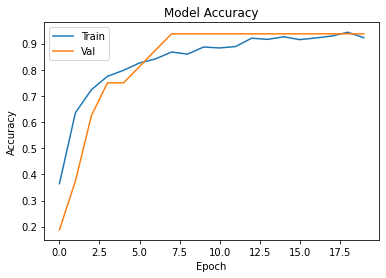

In [17]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

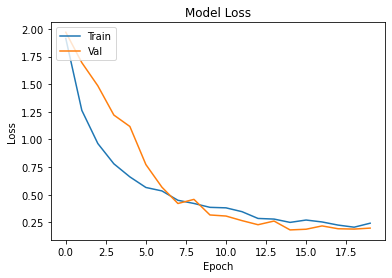

In [18]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [21]:
target_names = ['mantled_howler','patas_monkey','bald_uakari','japanese_macaque','pygmy_marmoset','white_headed_capuchin','silvery_marmoset','common_squirrel_monkey','black_headed_night_monkey','nilgiri_langur']

In [33]:
from sklearn.metrics import classification_report, confusion_matrix
Y_pred = model.predict_generator(val)
y_pred = np.argmax(Y_pred, axis=1)
cm = confusion_matrix(val.classes, y_pred)

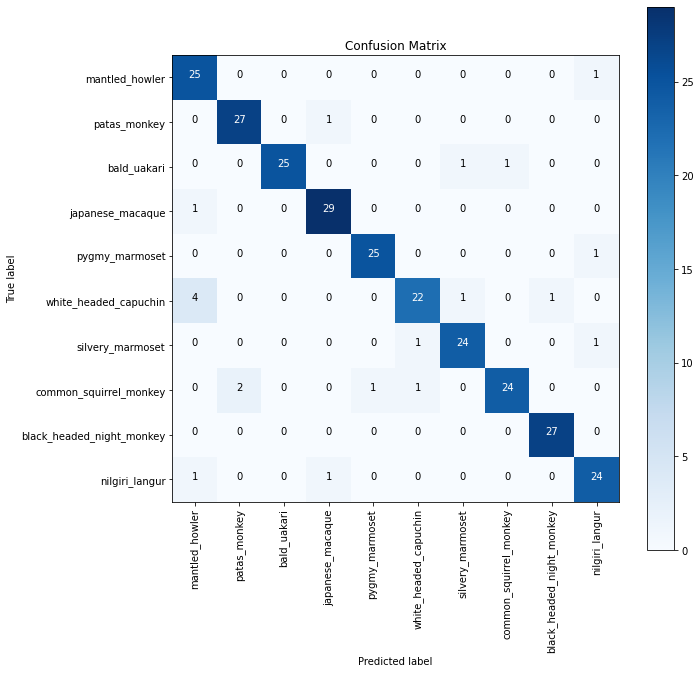

In [34]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(10)
plt.xticks(tick_marks, target_names, rotation=90)
plt.yticks(tick_marks, target_names)
plt.ylabel('True label')
plt.xlabel('Predicted label')
thresh = cm.max() / 2.
for i in range (cm.shape[0]):
    for j in range (cm.shape[1]):
        plt.text(j, i, cm[i, j],horizontalalignment="center",color="white" if cm[i, j] > thresh else "black")
plt.show()

In [35]:
print('Classification Report')
print(classification_report(val.classes, y_pred, target_names=target_names))

Classification Report
                           precision    recall  f1-score   support

           mantled_howler       0.81      0.96      0.88        26
             patas_monkey       0.93      0.96      0.95        28
              bald_uakari       1.00      0.93      0.96        27
         japanese_macaque       0.94      0.97      0.95        30
           pygmy_marmoset       0.96      0.96      0.96        26
    white_headed_capuchin       0.92      0.79      0.85        28
         silvery_marmoset       0.92      0.92      0.92        26
   common_squirrel_monkey       0.96      0.86      0.91        28
black_headed_night_monkey       0.96      1.00      0.98        27
           nilgiri_langur       0.89      0.92      0.91        26

                 accuracy                           0.93       272
                macro avg       0.93      0.93      0.93       272
             weighted avg       0.93      0.93      0.93       272

